Compile protein/protein structure related data (indexed by transcript)

In [17]:
from collections import defaultdict
import pandas as pd, os
from file_parsing_utils import parse_GFF
from helper_utils import transcript_to_gene_ID, AA3_to_aa1_dict, aa1_to_aa3_dict
import numpy as np
from pdbecif.mmcif_tools import MMCIF2Dict
from tqdm import tqdm
from Bio import pairwise2
import pickle

REF_DATA_DIR = '/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA'
REF_GENOME_DIR = f'/storage/NFS/GENOME_RESOURCES/p_fal/3D7'

BLOSUM62 min and max: -4.0 11.0
PAM250 min and max: -8.0 17.0


In [18]:
# Firstly get list of transcripts in Pf3D7 genome
gene_df = pd.read_csv(f'{REF_DATA_DIR}/pfal/Pf3D7_Gene_Annotations_FULL_v14.csv')
gene_df.set_index('Transcript ID', inplace=True, verify_integrity=True)

# Initialize table of protein data to build up
desired_columns = ['Transcript Product Description', 'Protein Sequence', 'Protein Length',
                   'Uniprot IDs', 'Molecular Weight', 'Isoelectric Point', 'Num TM Domains', 'PDB IDs']

PROTEIN_INFO_DICT = gene_df[desired_columns].to_dict(orient='index')
for transcript in PROTEIN_INFO_DICT:
    if pd.isna(PROTEIN_INFO_DICT[transcript]['Uniprot IDs']):
        PROTEIN_INFO_DICT[transcript]['Uniprot IDs'] = set([])
    else:
        PROTEIN_INFO_DICT[transcript]['Uniprot IDs'] = set(PROTEIN_INFO_DICT[transcript]['Uniprot IDs'].split(','))

In [22]:
# Cross check with reference genome data
ftype_feature_info_dict, feature_sequence_dict = parse_GFF(f'{REF_GENOME_DIR}/p_fal.gff')
# print('\n'.join([f'{ftype}: {list(ftype_feature_info_dict[ftype].keys())[0]}' for ftype in ftype_feature_info_dict]))

def convert_GFF_ID_to_transcript_ID(feature_ID): 
    if '.' in feature_ID: # Assume form rna_PF3D7_0105400.1-1
        return feature_ID.lstrip('rna_').split('-')[0]
    else: # Assume form rna_PF3D7_0100100-1
        return feature_ID.lstrip('rna_').replace('-', '.')

pseudogenes = []
for feature_ID in ftype_feature_info_dict['gene']:
    chrom, start, end, strand, attribute_dict = ftype_feature_info_dict['gene'][feature_ID]
    if 'pseudogene' in attribute_dict['description']:
        pseudogenes.append(feature_ID)

old_transcripts_missing = [] # Pseudogenes, not current identifier, or otherwise not present in PlasmoDB 66
old_transcripts_sequence_mismatch = [] # Transcripts where protein sequence does not match in v13 reference GFF and PlasmoDB 66

for ftype in ['mRNA', 'transcript']:
    for feature_ID in ftype_feature_info_dict[ftype]:
        transcript_ID = convert_GFF_ID_to_transcript_ID(feature_ID)
        
        if transcript_to_gene_ID(transcript_ID) in pseudogenes:
            continue
        
        if transcript_ID not in PROTEIN_INFO_DICT:
            old_transcripts_missing.append(transcript_ID)
        elif feature_sequence_dict[feature_ID] != PROTEIN_INFO_DICT[transcript_ID]['Protein Sequence']:
            old_transcripts_sequence_mismatch.append(transcript_ID)

            seq1 = feature_sequence_dict[feature_ID]
            seq2 = PROTEIN_INFO_DICT[transcript_ID]['Protein Sequence']
            '''
            print(transcript_ID)
            alignments = pairwise2.align.globalms(seq1, seq2, match=2, mismatch=-5, open=-1, extend=-1, penalize_end_gaps=False)
            print(alignments[0].seqA)
            print(alignments[0].seqB)
            print()
            '''

In [23]:
# Get more UniProt mappings
transcript_protein_ID_dict = defaultdict(set)
protein_ID_transcript_dict = {}
transcript_protein_desc_dict = {}

# UniProt
with open(f'{REF_DATA_DIR}/pfal/uniprotkb_taxonomy_id_36329_2023_11_27.fasta', 'r') as f:
    for line in f:
        if line.startswith('>'):
            if 'GN' not in line:
                continue
            _, protein, rest = line.strip('\n').split('|')
            other_id = rest.split(' ')[0]
            desc = ' '.join(rest.split('OS=')[0].split()[1:])
            transcript = rest.split('GN=')[1].split()[0]
            if not transcript.startswith('PF3D7'): # Non-canonical gene name
                continue
            if '.' not in transcript:
                transcript += '.1'
            protein_ID_transcript_dict[protein] = transcript
            transcript_protein_ID_dict[transcript].add(protein)
            transcript_protein_desc_dict[transcript] = desc # Each transcript maps to one protein description

# PlasmoDB (skip for now, should be redundant with gene annotation table)
with open(f'{REF_DATA_DIR}/pfal/Pf_Uniprot_PlasmoDB_idmapping_2024_01_12.tsv') as f:
    header = f.readline()
    for line in f:
        uniprot_id, veupathdb_str = line.strip('\n').split('\t')
        if '3D7' in veupathdb_str:
            gene_id = veupathdb_str.split('DB:')[1].strip('\n')

# Manually fix descriptions
transcript_protein_desc_dict['PF3D7_API04300'] = "DNA-directed RNA polymerase subunit beta"
transcript_protein_desc_dict['PF3D7_API02900'] = "Elongation factor Tu, apicoplast"
transcript_protein_desc_dict['PF3D7_1335400'] = "Reticulocyte-binding protein homolog 2a"
transcript_protein_desc_dict['PF3D7_0316300'] = "Probable inorganic pyrophosphatase"

for transcript in transcript_protein_ID_dict:
    set1 = transcript_protein_ID_dict[transcript]
    set2 = PROTEIN_INFO_DICT[transcript]['Uniprot IDs']
    PROTEIN_INFO_DICT[transcript]['Uniprot IDs'] = set1.union(set2)
    PROTEIN_INFO_DICT[transcript]['Uniprot Description'] = transcript_protein_desc_dict[transcript]

In [5]:
def get_AlphaFold3_pLDDT_data(gene_or_transcript, cif_filepath, offset=1):
    transcript = gene_or_transcript if '.' in gene_or_transcript else (gene_or_transcript + '.1')
    # cif_filepath = f"/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/AlphaFold3_CIFs/{gene_or_transcript}.cif"

    mmcif_dict = MMCIF2Dict()
    cif_dict = mmcif_dict.parse(cif_filepath)

    identifier = list(cif_dict.keys())[0]
    sequence = PROTEIN_INFO_DICT[transcript]['Protein Sequence']

    position_pLDDTs_dict = defaultdict(list)

    for AA3, position, pLDDT in zip(*[cif_dict[identifier]['_atom_site'][col] for col in ['label_comp_id', 'label_seq_id', 'B_iso_or_equiv']]):
        aa1 = AA3_to_aa1_dict[AA3]
        pos_idx = int(position)-1 + offset-1
        if sequence[pos_idx] != aa1: # Sanity check
            print(AA3, position, pLDDT, sequence[pos_idx])
        position_pLDDTs_dict[int(position)].append(float(pLDDT))

    position_avg_pLDDT_dict = { pos + offset-1 : np.mean(position_pLDDTs_dict[pos]) for pos in position_pLDDTs_dict }
    return position_avg_pLDDT_dict

In [ ]:
def combine_AlphaFold3_partial_pLDDT_data(gene_or_transcript, cif_dir):
    transcript = gene_or_transcript if '.' in gene_or_transcript else (gene_or_transcript + '.1')
    sequence = PROTEIN_INFO_DICT[transcript]['Protein Sequence']

    cif_interval_dict = {}
    for filename in os.listdir(cif_dir):
        if filename.startswith(gene_or_transcript):
            start, end = filename.split('.cif')[0].split('_')[2].split('-')
            cif_interval_dict[filename] = (int(start), int(end))
    
    combined_position_pLDDTs_dict = defaultdict(list)

    for filename in cif_interval_dict:
        cif_filepath = f"{cif_dir}/{filename}"
        start, end = cif_interval_dict[filename]
        
        combining_start = start if (start == 1) else (start + 150)
        combining_end = end if (end == len(sequence)) else (end - 150)
        
        position_avg_pLDDT_dict = get_AlphaFold3_pLDDT_data(gene_or_transcript, cif_filepath, offset=start)

        for pos in np.arange(combining_start, combining_end+1):
            combined_position_pLDDTs_dict[pos].append(position_avg_pLDDT_dict[pos])

    combined_position_avg_pLDDT_dict = { pos: np.mean(combined_position_pLDDTs_dict[pos]) for pos in combined_position_pLDDTs_dict }
    return combined_position_avg_pLDDT_dict

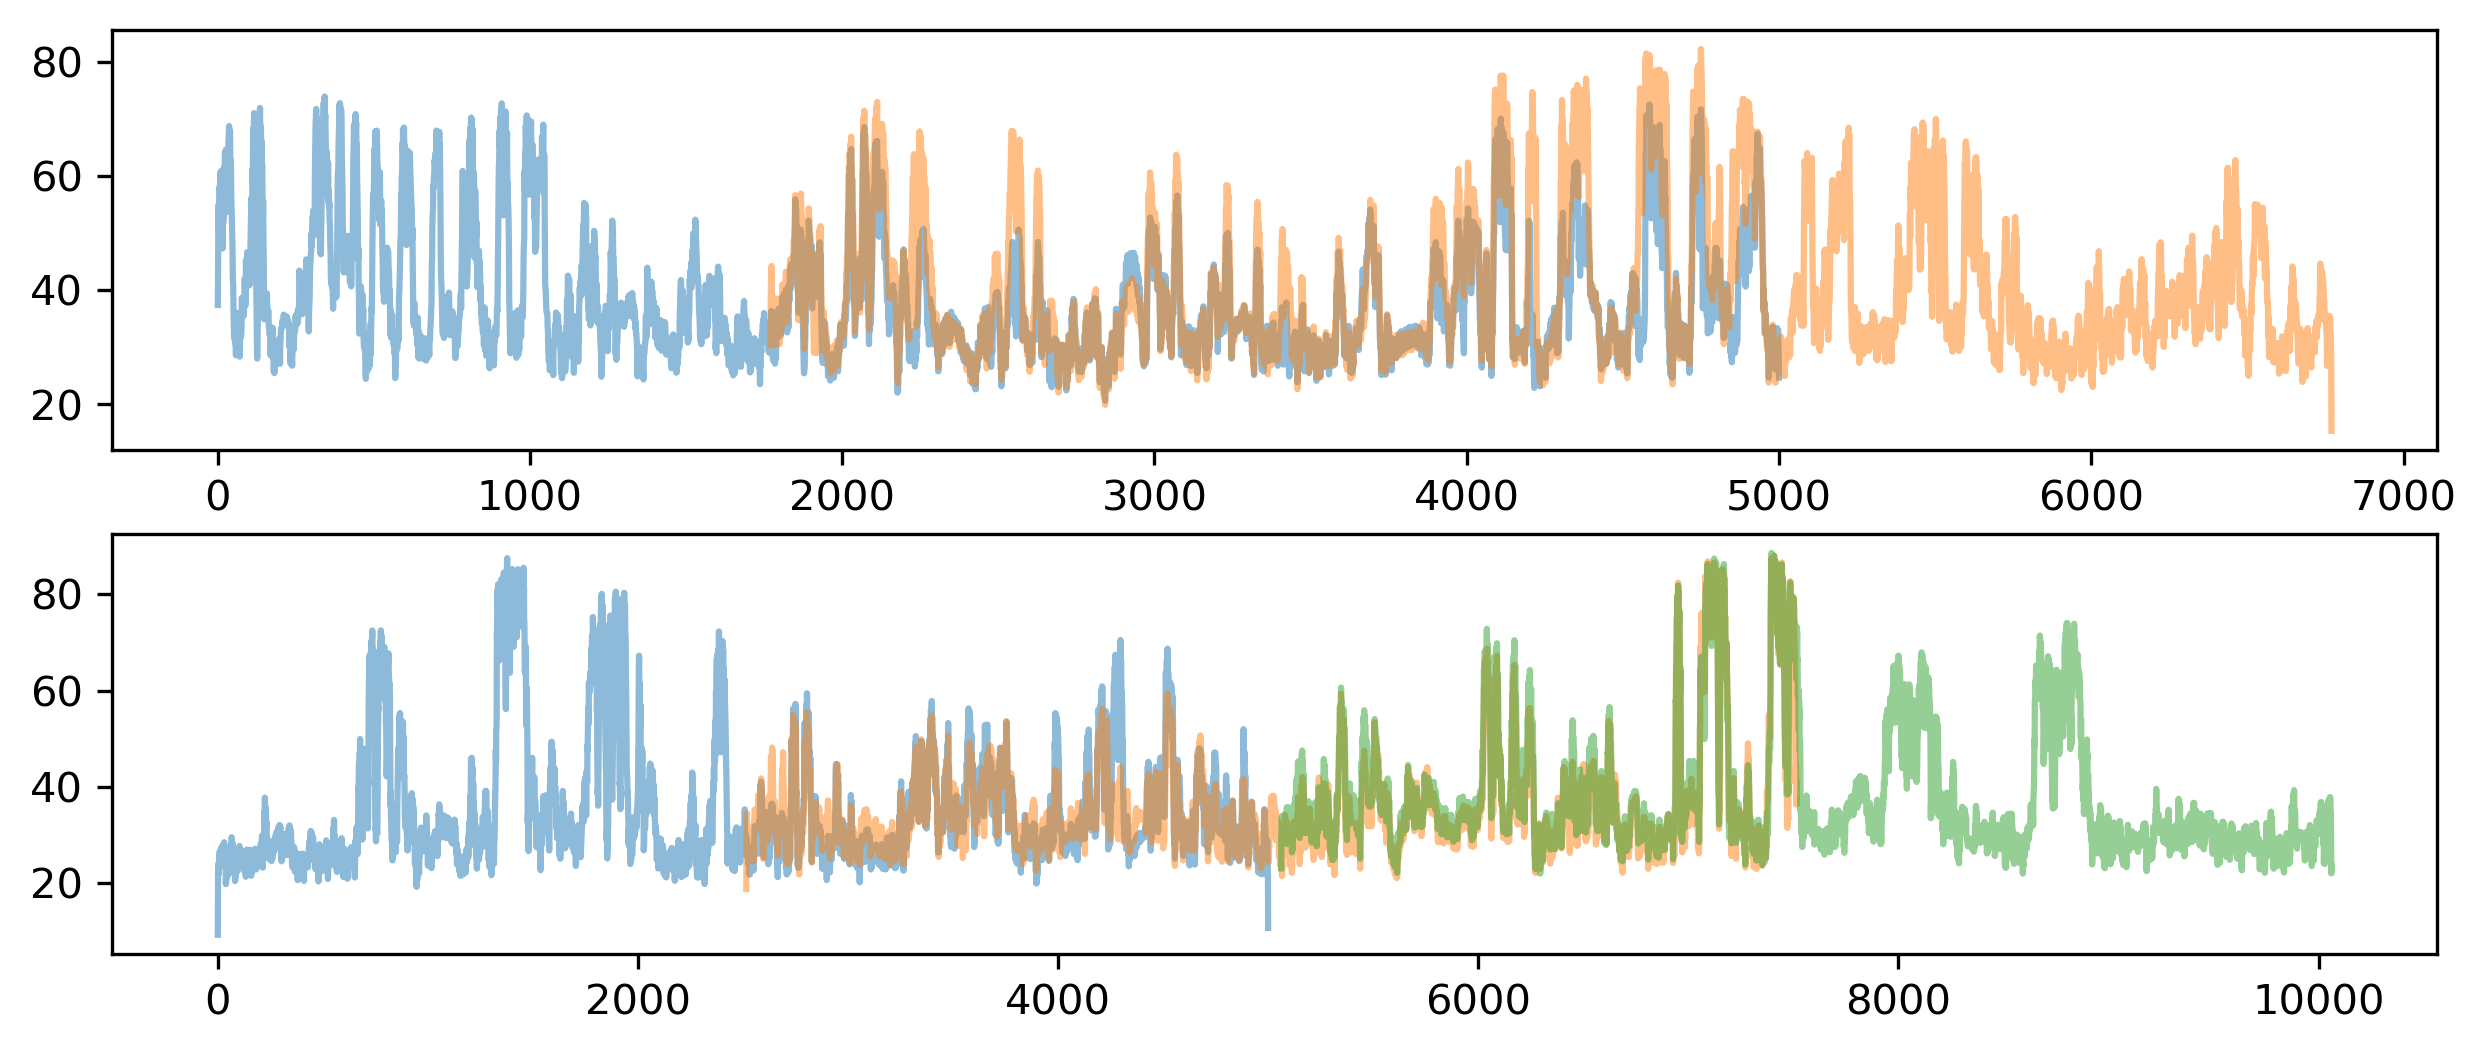

In [7]:
# Prototyping

import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['figure.dpi'] = 300

gene = 'PF3D7_0417400'
cif_filepath = f"/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/AlphaFold3_Partial_CIFs/PF3D7_0417400_1-5000.cif"
cif_filepath_2 = f"/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/AlphaFold3_Partial_CIFs/PF3D7_0417400_1770-6769.cif"

position_avg_pLDDT_dict1 = get_AlphaFold3_pLDDT_data(gene, cif_filepath)
position_avg_pLDDT_dict2 = get_AlphaFold3_pLDDT_data(gene, cif_filepath_2, offset=1770)

fig, ax = plt.subplots(2, 1, figsize=(10, 4))
x1s = sorted(position_avg_pLDDT_dict1.keys())
x2s = sorted(position_avg_pLDDT_dict2.keys())
ax[0].plot(x1s, [position_avg_pLDDT_dict1[pos] for pos in x1s], '-', alpha=0.5)
ax[0].plot(x2s, [position_avg_pLDDT_dict2[pos] for pos in x2s], '-', alpha=0.5)

gene = 'PF3D7_0511500'
cif_filepath = f"/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/AlphaFold3_Partial_CIFs/PF3D7_0511500_1-5000.cif"
cif_filepath_2 = f"/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/AlphaFold3_Partial_CIFs/PF3D7_0511500_2516-7515.cif"
cif_filepath_3 = f"/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/AlphaFold3_Partial_CIFs/PF3D7_0511500_5062-10061.cif"
    
position_avg_pLDDT_dict1 = get_AlphaFold3_pLDDT_data(gene, cif_filepath)
position_avg_pLDDT_dict2 = get_AlphaFold3_pLDDT_data(gene, cif_filepath_2, offset=2516)
position_avg_pLDDT_dict3 = get_AlphaFold3_pLDDT_data(gene, cif_filepath_3, offset=5062)

x1s = sorted(position_avg_pLDDT_dict1.keys())
x2s = sorted(position_avg_pLDDT_dict2.keys())
x3s = sorted(position_avg_pLDDT_dict3.keys())
ax[1].plot(x1s, [position_avg_pLDDT_dict1[pos] for pos in x1s], '-', alpha=0.5)
ax[1].plot(x2s, [position_avg_pLDDT_dict2[pos] for pos in x2s], '-', alpha=0.5)
ax[1].plot(x3s, [position_avg_pLDDT_dict3[pos] for pos in x3s], '-', alpha=0.5)
plt.show()

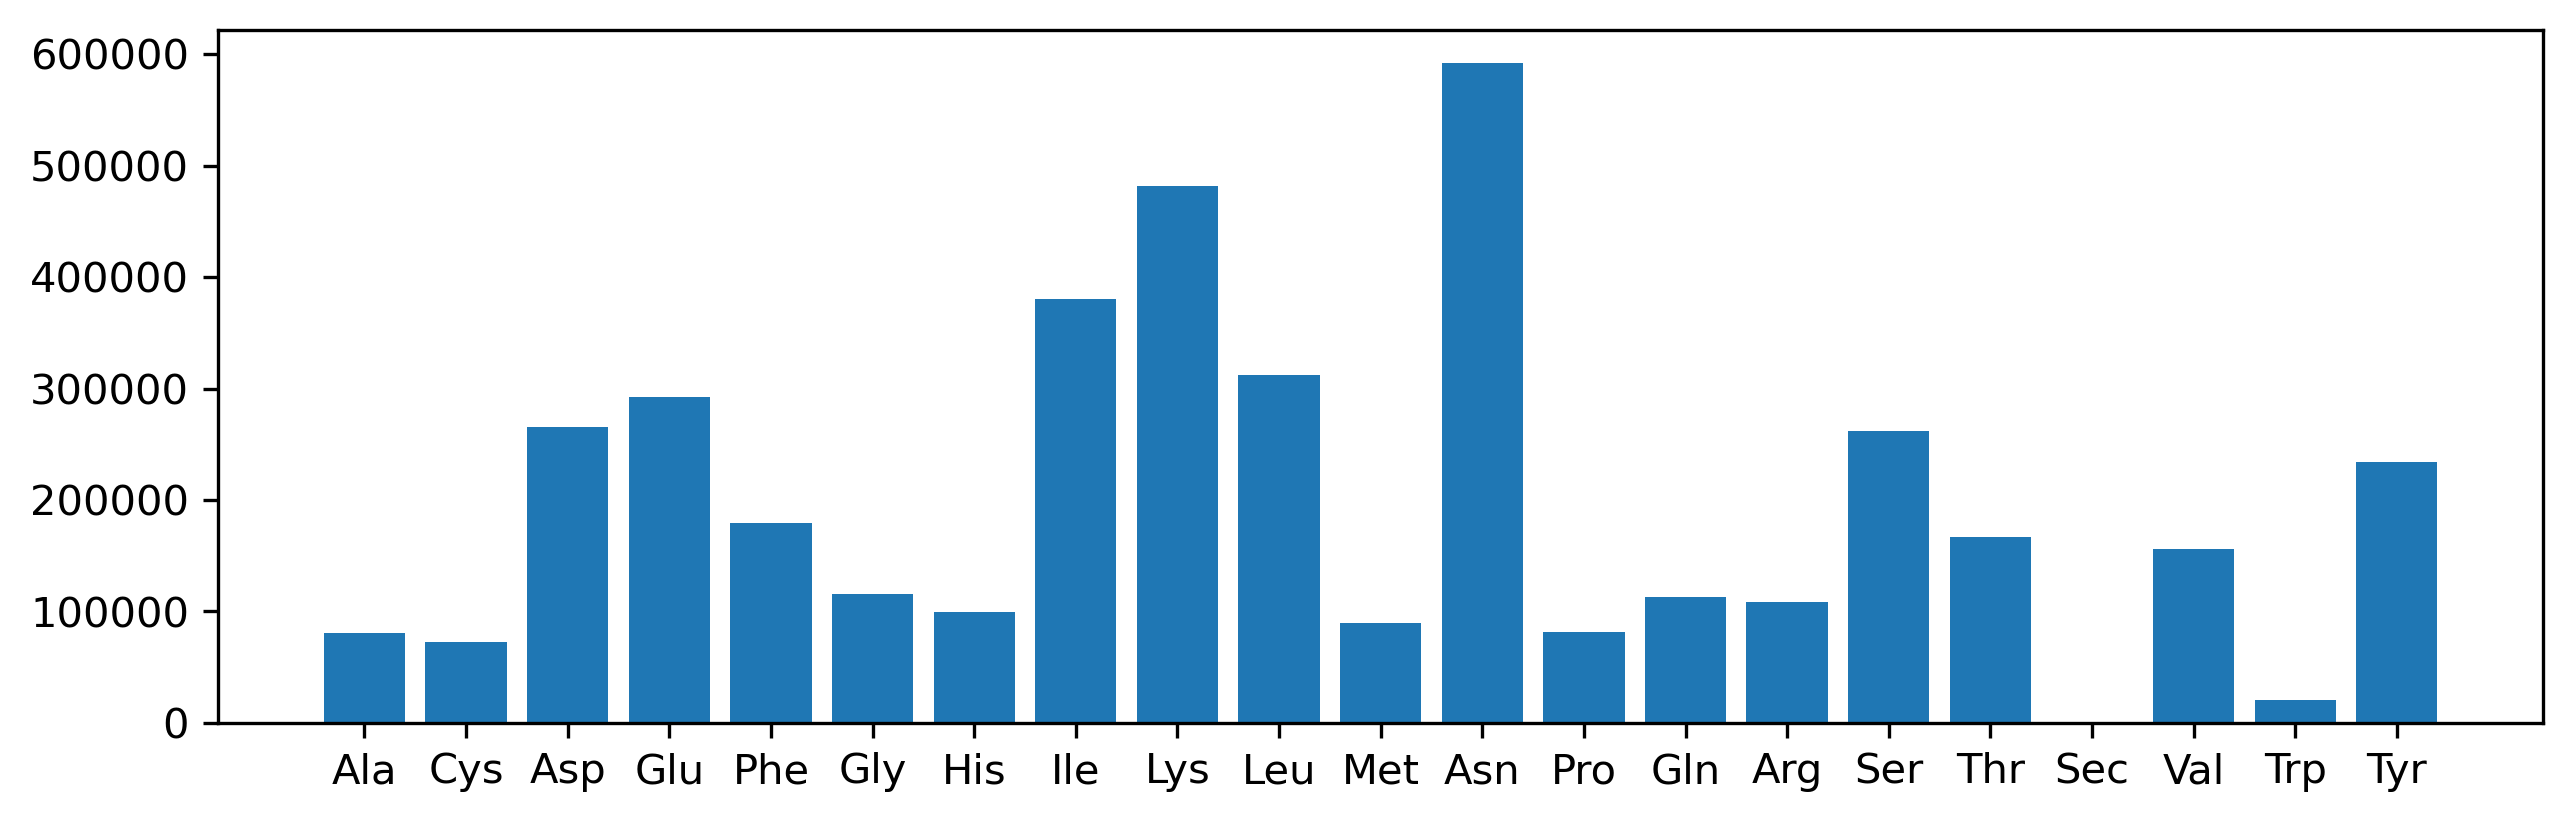

In [8]:
amino_acid_freq_dict = defaultdict(int)
for transcript in PROTEIN_INFO_DICT:
    sequence = PROTEIN_INFO_DICT[transcript]['Protein Sequence']
    for aa1 in sequence:
        amino_acid_freq_dict[aa1] += 1

fig, ax = plt.subplots(figsize=(10,3))
xs = np.arange(len(amino_acid_freq_dict))
sorted_aa1s = sorted(amino_acid_freq_dict.keys())
sorted_aa3s = ['Sec' if aa1 == 'U' else aa1_to_aa3_dict[aa1] for aa1 in sorted_aa1s]

ax.bar(xs, [amino_acid_freq_dict[aa1] for aa1 in sorted_aa1s])
ax.set_xticks(xs); ax.set_xticklabels(sorted_aa3s)
plt.show()

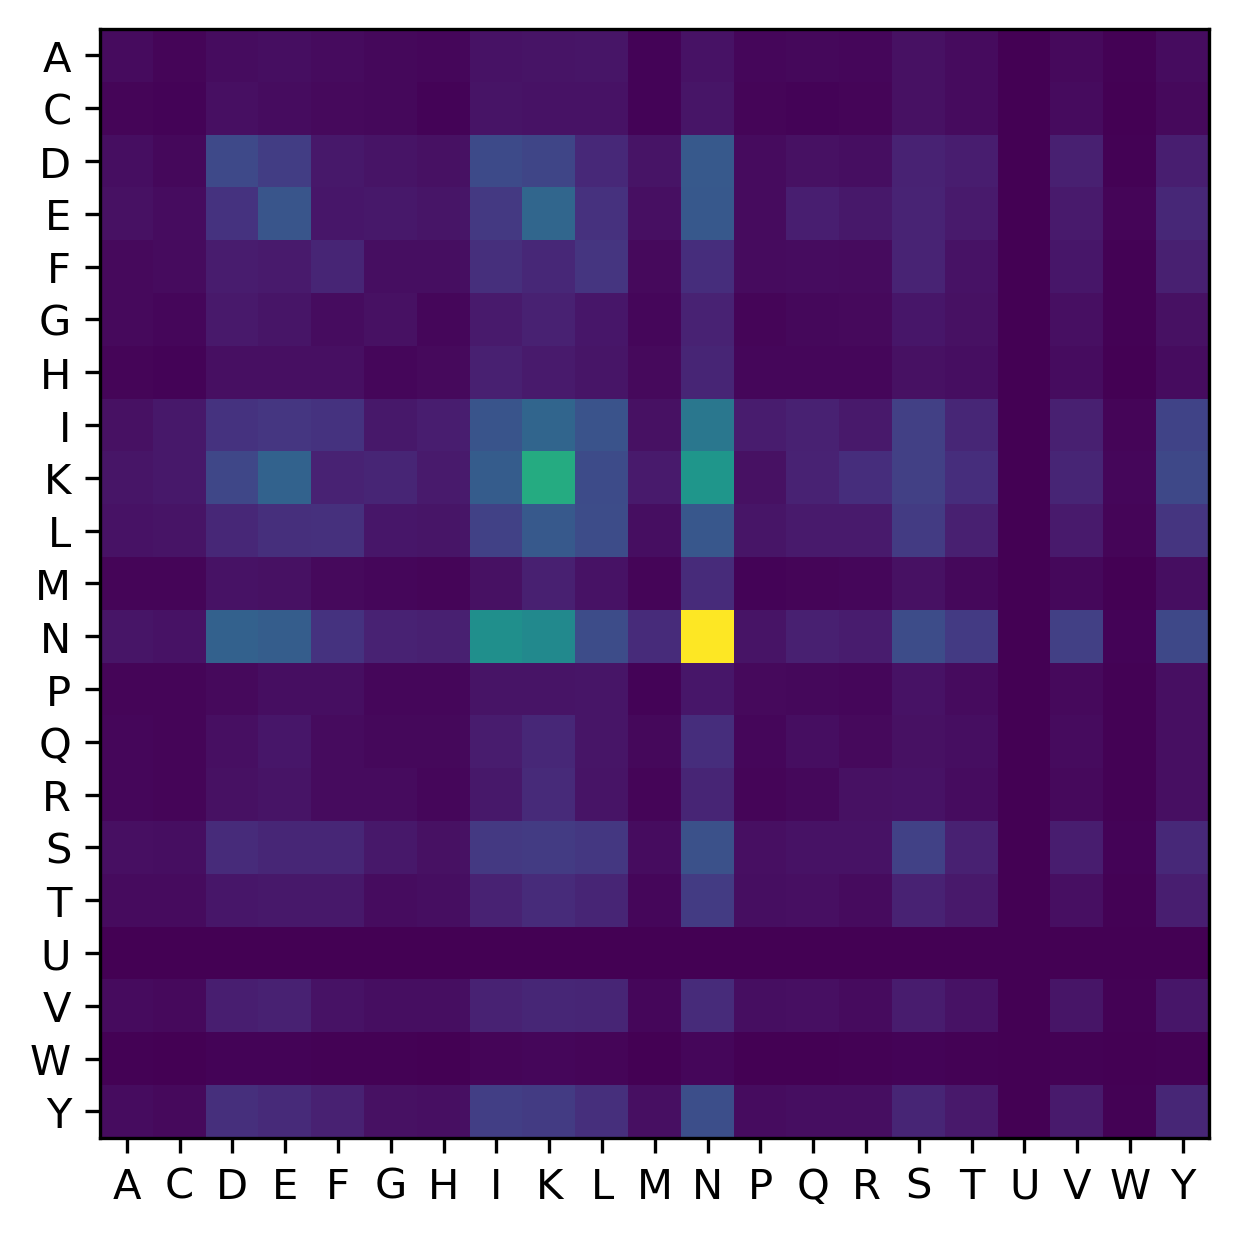

In [9]:
# 2-mer heatmap

k = 2
kmer_freq_dict = defaultdict(int)

for transcript in PROTEIN_INFO_DICT:
    sequence = PROTEIN_INFO_DICT[transcript]['Protein Sequence']
    for i in range(len(sequence)-k):
        kmer = sequence[i:i+k]
        kmer_freq_dict[kmer] += 1

aa_2mer_freq_dict = {aa1: defaultdict(int) for aa1 in sorted_aa1s}
for kmer in kmer_freq_dict:
    aa_2mer_freq_dict[kmer[0]][kmer[1]] = kmer_freq_dict[kmer]

heatmap = np.array([[aa_2mer_freq_dict[a][b] for b in sorted_aa1s] for a in sorted_aa1s])

fig, ax = plt.subplots()
ax.imshow(heatmap)
ax.set_xticks(np.arange(len(sorted_aa1s))); ax.set_xticklabels(sorted_aa1s)
ax.set_yticks(np.arange(len(sorted_aa1s))); ax.set_yticklabels(sorted_aa1s)

plt.show()

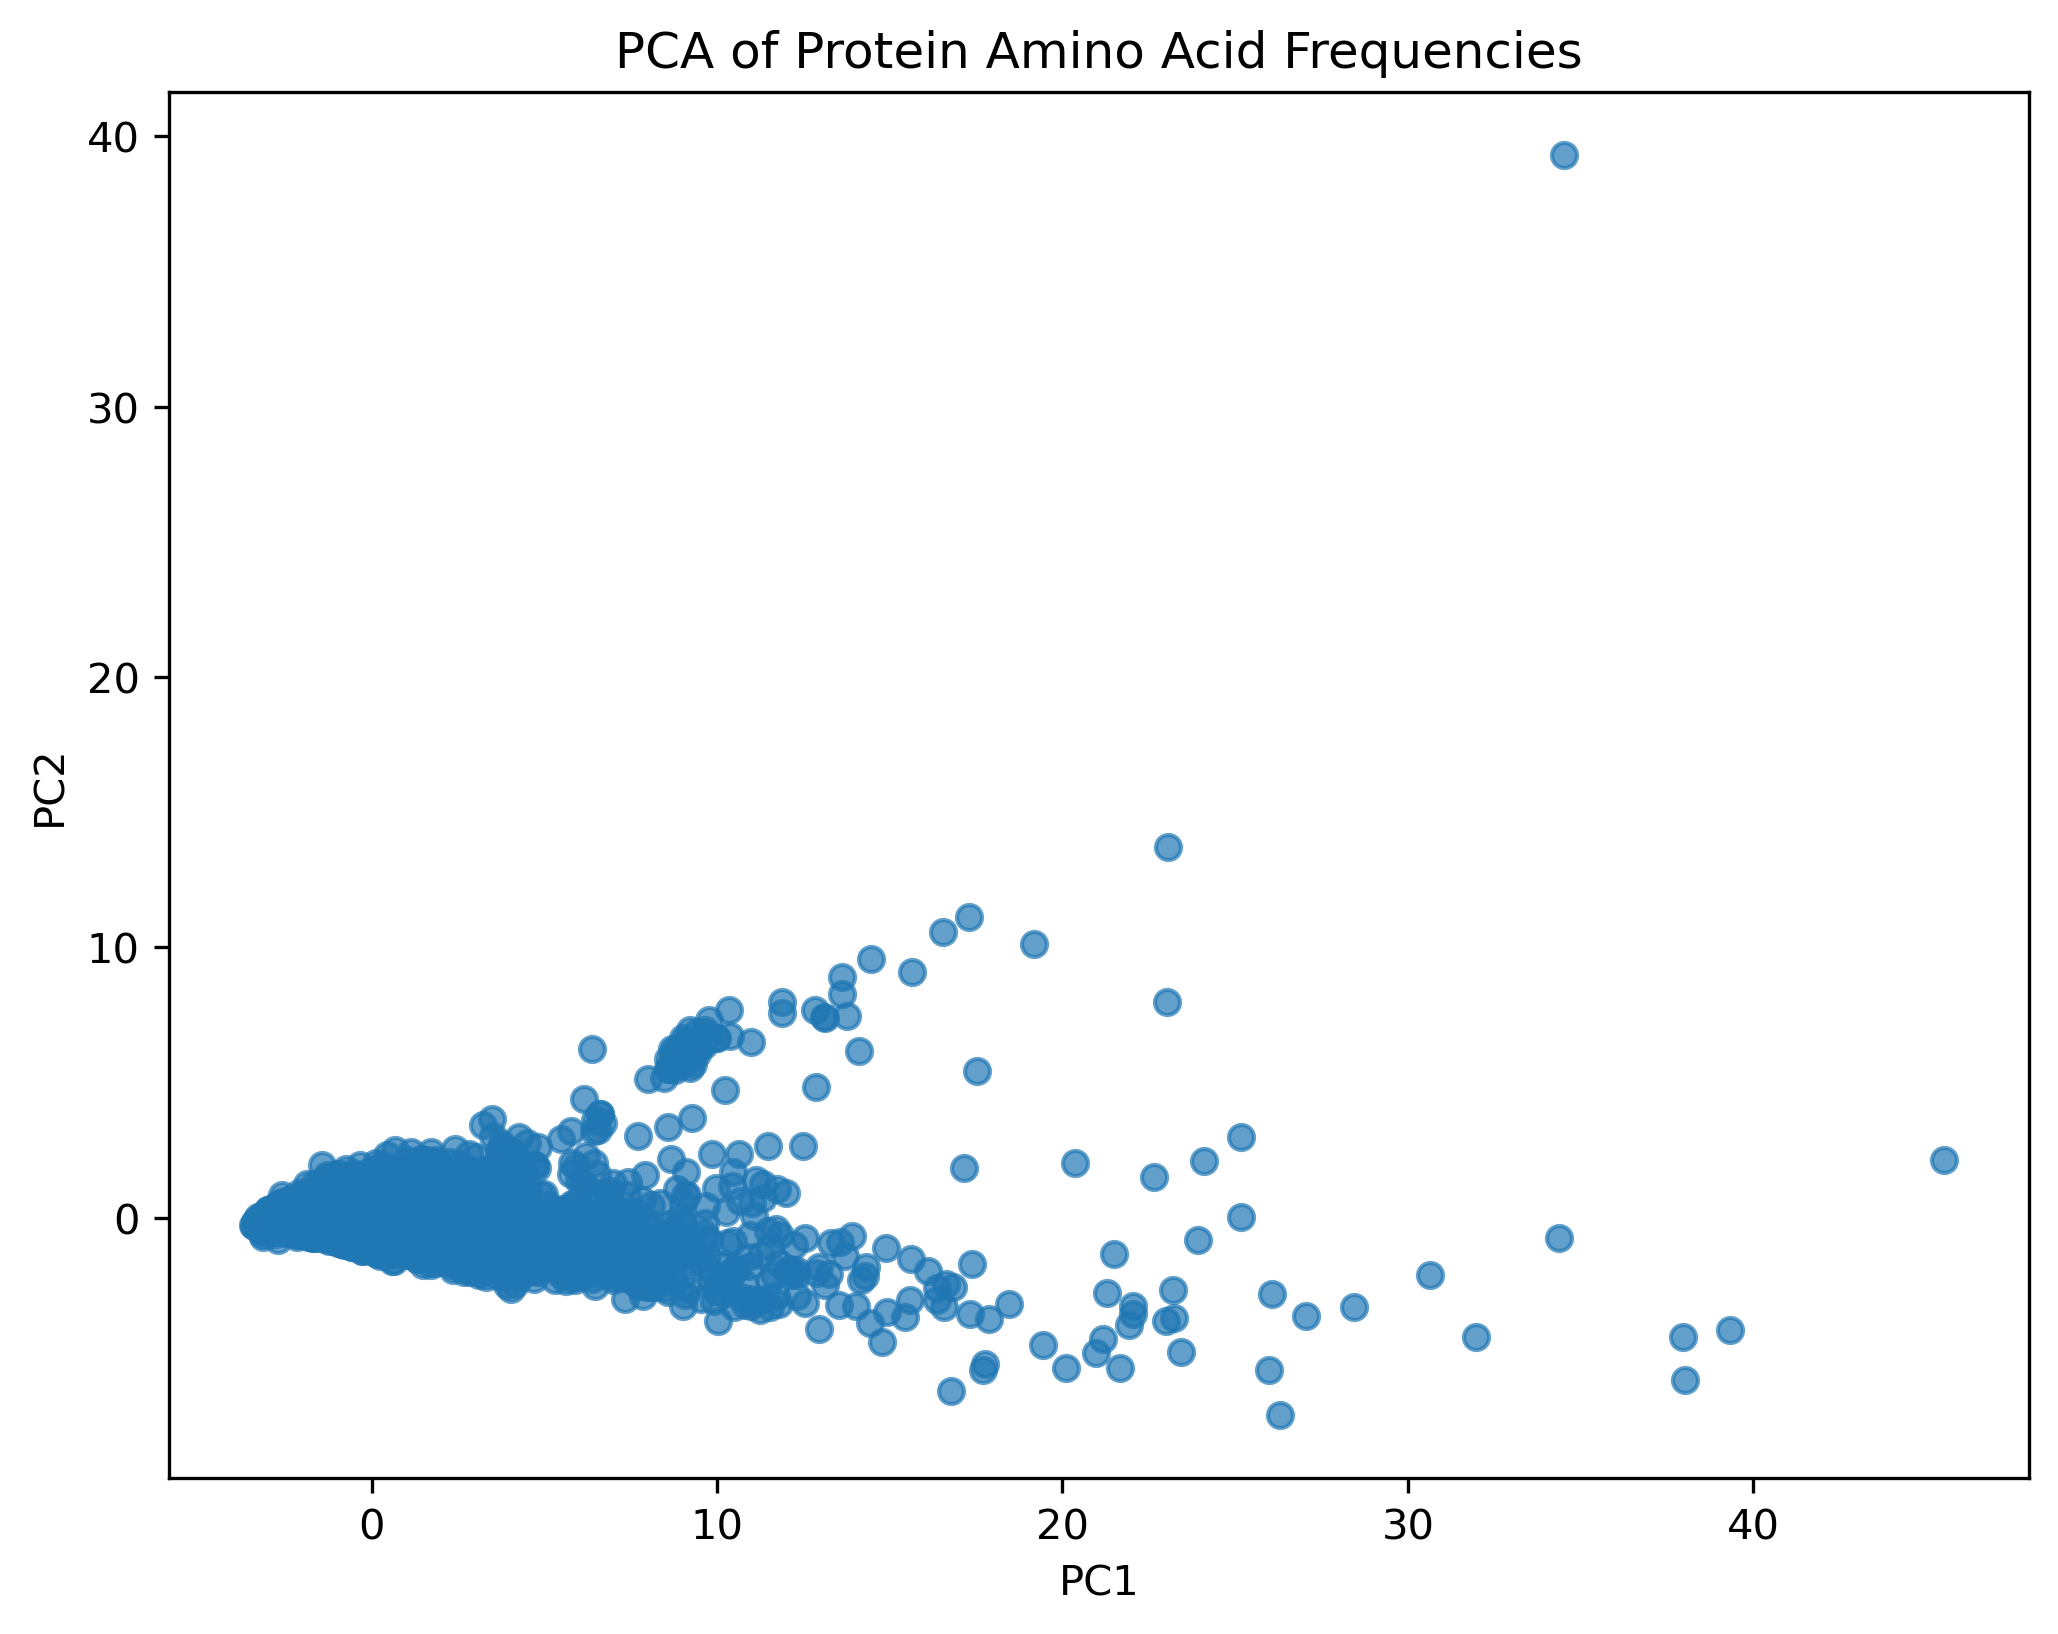

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Try clustering proteins by amino acid composition

protein_amino_acid_freq_dict = {}
for transcript in PROTEIN_INFO_DICT:
    amino_acid_freq_dict = defaultdict(int)
    sequence = PROTEIN_INFO_DICT[transcript]['Protein Sequence']
    for aa1 in sequence:
        amino_acid_freq_dict[aa1] += 1
    protein_amino_acid_freq_dict[transcript] = amino_acid_freq_dict

sorted_proteins = sorted(protein_amino_acid_freq_dict.keys())

data_matrix = np.array([
    [protein_amino_acid_freq_dict[protein].get(aa, 0) for aa in sorted_aa1s]
    for protein in sorted_proteins
])

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_matrix)

# Perform PCA
pca = PCA(n_components=8)
pca_result = pca.fit_transform(data_scaled)

# Scatter plot of first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Protein Amino Acid Frequencies")
plt.show()

In [13]:
def get_AlphaFoldDB_pLDDT_data(gene_or_transcript, cif_filepath):
    # cif_filepath = "/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/AlphaFold_CIFs/{gene_or_transcript}.cif"
    mmcif_dict = MMCIF2Dict()
    cif_dict = mmcif_dict.parse(cif_filepath)

    identifier = list(cif_dict.keys())[0]
    sequence = ''.join(cif_dict[identifier]['_entity_poly']['pdbx_seq_one_letter_code_can'].split('\n'))
    position_pLDDT_dict = {} # pLDDTs = np.array(cif_dict[identifier]['_ma_qa_metric_local']['metric_value'])

    # Sanity check
    for AA3, position, pLDDT in zip(*[cif_dict[identifier]['_ma_qa_metric_local'][col] for col in ['label_comp_id', 'label_seq_id', 'metric_value']]):
        aa1 = AA3_to_aa1_dict[AA3]
        pos_idx = int(position)-1
        if sequence[pos_idx] != aa1: # Sanity check
            print(AA3, position, pLDDT, sequence[pos_idx])
        position_pLDDT_dict[int(position)] = float(pLDDT)
    
    return position_pLDDT_dict


In [25]:
# Get AlphaFold structure information
protein_aa_pLDDT_dict = defaultdict(dict)

proteins_missing_structure = []

AF3_folder = '/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/AlphaFold3_CIFs'
AF3_partial_folder = '/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/AlphaFold3_Partial_CIFs'
AFDB_folder = '/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/AlphaFold_CIFs'

big_genes = {'_'.join(fname.split('_')[:2]) for fname in os.listdir(AF3_partial_folder)}

for transcript in tqdm(PROTEIN_INFO_DICT):
    gene = transcript_to_gene_ID(transcript)
    
    file_failed = False

    if gene in big_genes:
        position_pLDDT_dict[transcript] = combine_AlphaFold3_partial_pLDDT_data(gene, AF3_partial_folder)
    else:
        if os.path.exists(f'{AF3_folder}/{transcript}.cif'):
            position_pLDDT_dict = get_AlphaFold3_pLDDT_data(transcript, f'{AF3_folder}/{transcript}.cif')
        elif os.path.exists(f'{AF3_folder}/{gene}.cif'):
            position_pLDDT_dict = get_AlphaFold3_pLDDT_data(gene, f'{AF3_folder}/{gene}.cif')
        elif os.path.exists(f'{AFDB_folder}/{transcript}.cif'):
            try:
                position_pLDDT_dict = get_AlphaFoldDB_pLDDT_data(transcript, f'{AFDB_folder}/{transcript}.cif')
            except:
                file_failed = True
        elif os.path.exists(f'{AFDB_folder}/{gene}.cif'):
            try:
                position_pLDDT_dict = get_AlphaFoldDB_pLDDT_data(gene, f'{AFDB_folder}/{gene}.cif')
            except:
                file_failed = True
        else:
            file_failed = True
    
    if file_failed:
        proteins_missing_structure.append(transcript)
    else:
        protein_aa_pLDDT_dict[transcript] = position_pLDDT_dict

 35%|███▌      | 1908/5389 [01:14<01:27, 39.79it/s]

CYS 26 22.07 U
CYS 26 24.58 U
CYS 26 25.20 U
CYS 26 23.84 U
CYS 26 22.60 U
CYS 26 19.46 U


 45%|████▍     | 2407/5389 [01:30<01:23, 35.51it/s]

CYS 72 57.83 U
CYS 72 57.89 U
CYS 72 59.14 U
CYS 72 54.85 U
CYS 72 54.68 U
CYS 72 49.22 U


 86%|████████▌ | 4619/5389 [02:46<00:19, 40.28it/s]

CYS 115 46.64 U
CYS 115 50.50 U
CYS 115 47.42 U
CYS 115 43.18 U
CYS 115 50.33 U
CYS 115 45.69 U


 90%|████████▉ | 4842/5389 [02:54<00:17, 30.86it/s]

CYS 133 62.11 U
CYS 133 66.41 U
CYS 133 64.29 U
CYS 133 60.38 U
CYS 133 63.30 U
CYS 133 54.71 U


100%|██████████| 5389/5389 [03:14<00:00, 27.71it/s]


In [27]:
pickle.dump(protein_aa_pLDDT_dict, open(f'{REF_DATA_DIR}/pfal/CompiledRefData/protein_aa_pLDDT_dict.pkl', 'wb'))

In [29]:
for transcript in PROTEIN_INFO_DICT:
    if transcript in old_transcripts_sequence_mismatch:
        PROTEIN_INFO_DICT[transcript]['Structure Status'] = 'Sequence Mismatch'
    elif transcript in proteins_missing_structure:
        PROTEIN_INFO_DICT[transcript]['Structure Status'] = 'AlphaFold Structure Missing'
    else:
        PROTEIN_INFO_DICT[transcript]['Structure Status'] = 'AlphaFold Structure'

In [30]:
df = pd.DataFrame.from_dict(PROTEIN_INFO_DICT, orient='index')
len(df[df['Structure Status'] != 'AlphaFold Structure'])

75

In [31]:
pickle.dump(PROTEIN_INFO_DICT, open(f'{REF_DATA_DIR}/pfal/CompiledRefData/protein_info_dict.pkl', 'wb'))

In [2]:
protein_domain_dict = defaultdict(list)
domain_info_dict = {}

with open(f'{REF_DATA_DIR}/pfal/InterProScan/PlasmoDB-66_Pfalciparum3D7_AnnotatedProteins.fasta.tsv', 'r') as f:

    for line in f:
        items = line.strip('\n').split('\t')
        # Note that match_status is always T, and GO/pathway analysis was not done
        protein_ID, seq_digest, seq_length, analysis, signature, signature_desc, \
        start, end, score, match_status, date, InterPro_accession, InterPro_anno, GO, pathway = items
        transcript_ID = protein_ID.split('-p')[0]
        start = int(start); end = int(end); seq_length = len(seq_length)
        
        protein_domain_dict[transcript_ID].append((signature, start, end))
        domain_info_dict[signature] = (signature_desc, analysis, InterPro_accession, InterPro_anno)

pickle.dump(protein_domain_dict, open(f'{REF_DATA_DIR}/pfal/CompiledRefData/protein_domain_dict.pkl', 'wb'))
pickle.dump(domain_info_dict, open(f'{REF_DATA_DIR}/pfal/CompiledRefData/domain_info_dict.pkl', 'wb'))

# The Encyclopedia of Domains (TED) structural domains assignments for AlphaFold Database v4
- Paper: https://www.science.org/doi/10.1126/science.adq4946
- Download source: https://zenodo.org/records/13908086
- CATH annotations: https://www.cathdb.info/wiki?id=data:index

In [11]:
CATH_code_name_dict = {}

f = open('/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/TED_Domains/CATH/cath-names.txt')
for line in f:
    if line.startswith('#'):
        continue
    prefix, desc = line.strip('\n').split(':', 1)
    code = prefix.split()[0]
    CATH_code_name_dict[code] = desc

In [3]:
TED_consensus_level_dict = {}
TED_chopping_dict = {}
TED_cath_label_dict = {}

f = open('/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/TED_Domains/pfam_36329.tsv', 'r')
for line in f:
    items = line.strip('\n').split('\t')
    ted_id = items[0] # AF-<UniProtID>-F1-model_v4_TED<domain_number_in_chain> i.e. AF-A0A1V6M2Y0-F1-model_v4_TED03
    md5_domain = items[1] # md5 hash of domain sequence
    consensus_level = items[2] # medium (2 methods agreement) or high (3 methods agreement)
    chopping = items[3] # domain boundaries in the format <start>-<stop> or <start>-<stop>_<start>-<stop> for discontinuous domains
    nres_domain = items[4] # number of residues in domain
    num_segments = items[5] # number of individual segments in domain. 
    plddt = items[6] # average pLDDT for domain (range from 0 to 100)
    num_helix_strand_turn = items[7] # number of helix strand turns predicted by STRIDE
    num_helix = items[8] # number of helices predicted by STRIDE
    num_strand = items[9] # number of strands predicted by STRIDE
    num_helix_strand = items[10] # number of helices and strands predicted by STRIDE
    num_turn = items[11] # number of turns predicted by STRIDE
    proteome_id = items[12] # proteome identifier in the format proteome-tax_id-<taxonID>-<shard>_v4 i.e. proteome-tax_id-67581-0_v4
    cath_label = items[13] # CATH superfamily code if predicted, either a C.A.T.H. homologous superfamily or C.A.T. fold assignment. i.e. 3.40.50.300. Otherwise '-'
    cath_assignment_level = items[14] # H for homologous superfamily assignment, T for fold level assignment. Otherwise '-'
    cath_assignment_method = items[15] # Method used to assign a CATH label, either foldseek or foldclass. Otherwise '-'
    packing_density = items[16] # metric used to determine globularity. A domain with packing_density > =10.333 and norm_rg below 0.356 is considered globular
    norm_rg = items[17] # normalised radius of gyration. A domain with packing_density > =10.333 AND norm_rg below 0.356 is considered globular. 
    tax_common_name = items[18] # Common name for organism
    tax_scientific_name = items[19] # Scientific name for organism
    tax_lineage = items[20] # Full taxonomic lineage
    
    TED_consensus_level_dict[ted_id] = consensus_level
    TED_chopping_dict[ted_id] = chopping
    TED_cath_label_dict[ted_id] = cath_label

print("%i TED domains" % len(TED_consensus_level_dict))

10509 TED domains


In [52]:
# Get UniProt -> Pf ID mappings

Uniprot_ID_gene_or_transcript_dict = defaultdict(set)

f = open('/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/UniProt_ID_mapping/idmapping_grep_PF3D7.tsv')
for line in f:
    items = line.strip('\n').split('\t')
    uniprot_id, id_type, pf_id = items
    if ':' in pf_id:
        pf_id = pf_id.split(':')[1]
    Uniprot_ID_gene_or_transcript_dict[uniprot_id].add(pf_id)

In [40]:
def parse_chopping(chopping):
    return [tuple([int(v) for v in interval.split('-')]) \
            for interval in chopping.split('_')]

In [53]:
protein_TED_domain_dict = defaultdict(list)
TED_domain_info_dict = {}

for domain in TED_cath_label_dict:
    consensus_level = TED_consensus_level_dict[domain]
    location = parse_chopping(TED_chopping_dict[domain])
    if cath_label != '-':
        cath_label = TED_cath_label_dict[domain]
        domain_desc = CATH_code_name_dict[cath_label]
    else:
        domain_desc = cath_label
    
    TED_domain_info_dict[domain] = (location, domain_desc, consensus_level)
    
    protein_ID = domain.split('AF-')[1].split('-F1-model_v4')[0]
    for gene_or_transcript in Uniprot_ID_gene_or_transcript_dict[protein_ID]:
        protein_TED_domain_dict[gene_or_transcript].append(domain)

In [59]:
pickle.dump(protein_TED_domain_dict, open(f'{REF_DATA_DIR}/pfal/CompiledRefData/protein_TED_domain_dict.pkl', 'wb'))
pickle.dump(TED_domain_info_dict, open(f'{REF_DATA_DIR}/pfal/CompiledRefData/TED_domain_info_dict.pkl', 'wb'))